ID,Age,OME,Loud,Noise,Correct,Trials
<int>,<int>,<fct>,<int>,<fct>,<int>,<int>
1,30,low,35,coherent,1,4
1,30,low,35,incoherent,4,5
1,30,low,40,coherent,0,3
1,30,low,40,incoherent,1,1
1,30,low,45,coherent,2,4
1,30,low,45,incoherent,2,2


[1] FALSE

'data.frame':	712 obs. of  7 variables:
 $ ID     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Age    : int  30 30 30 30 30 30 30 30 30 30 ...
 $ OME    : Factor w/ 2 levels "high","low": 2 2 2 2 2 2 2 2 2 2 ...
 $ Loud   : int  35 35 40 40 45 45 50 50 55 55 ...
 $ Noise  : Factor w/ 2 levels "coherent","incoherent": 1 2 1 2 1 2 1 2 1 2 ...
 $ Correct: int  1 4 0 1 2 2 3 4 3 2 ...
 $ Trials : int  4 5 3 1 4 2 3 4 3 2 ...


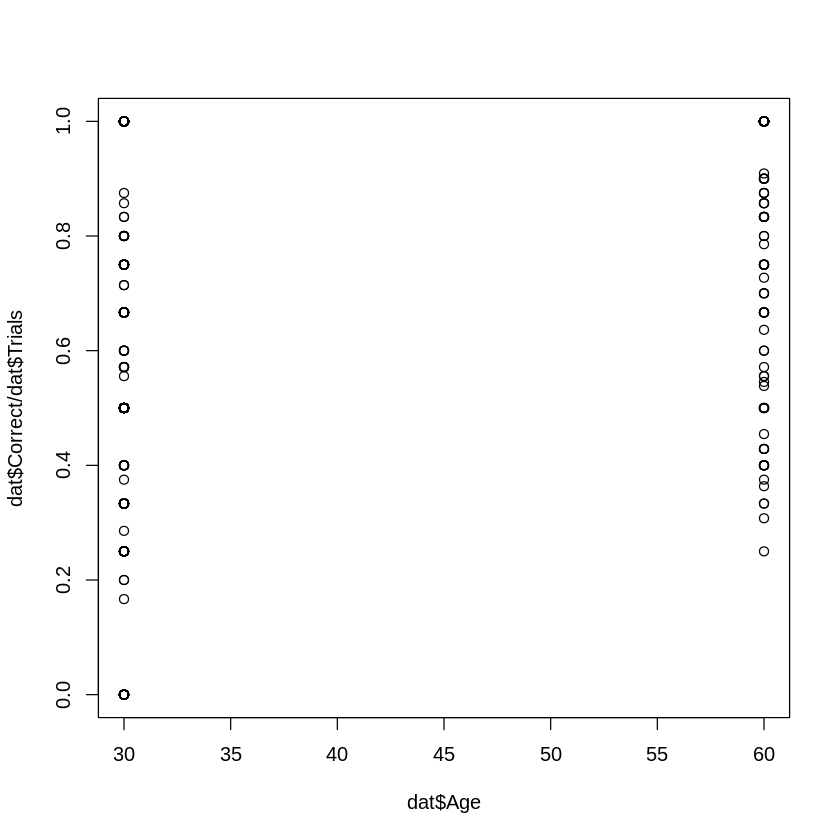

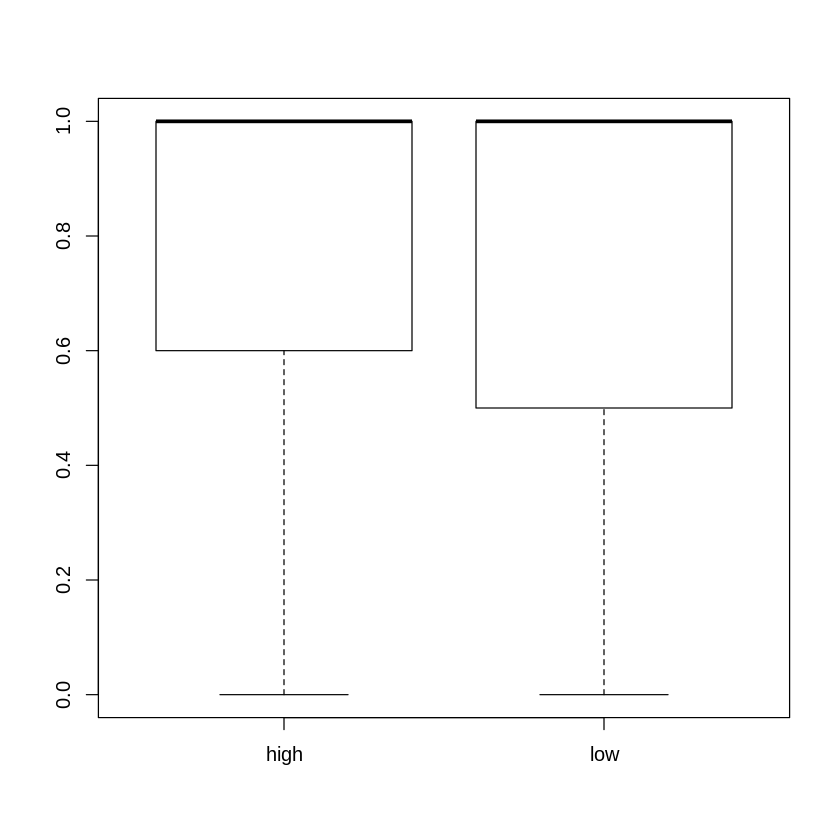

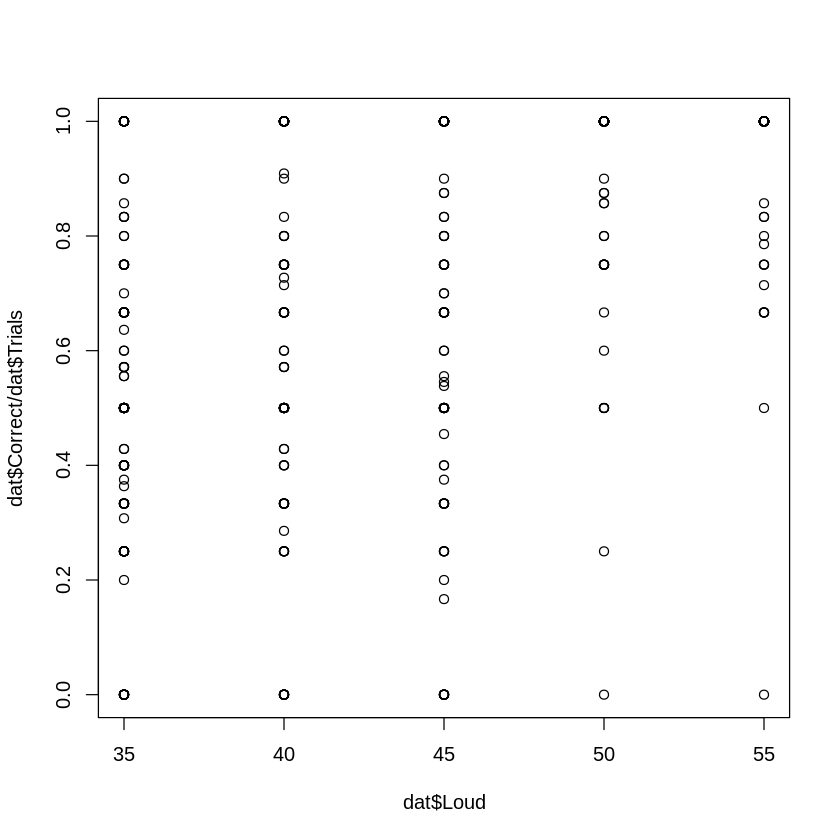

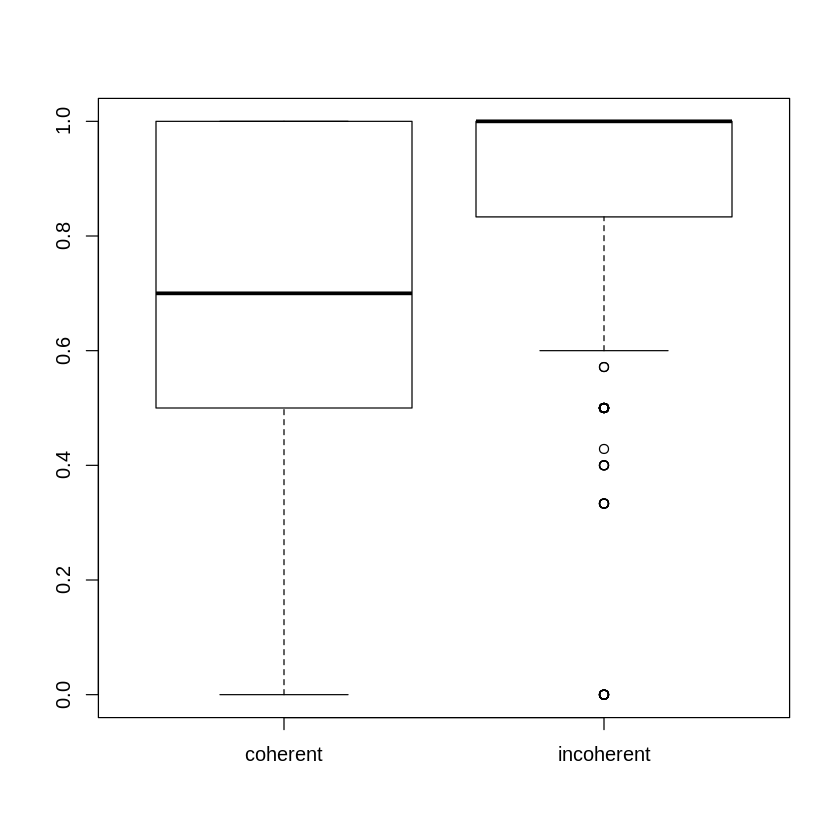

In [1]:
library("MASS")
data("OME")
?OME # background on the data
head(OME)

any(is.na(OME)) # check for missing values
dat = subset(OME, OME != "N/A") # manually remove OME missing values identified with "N/A"
dat$OME = factor(dat$OME)
str(dat)

plot(dat$Age, dat$Correct / dat$Trials )
plot(dat$OME, dat$Correct / dat$Trials )
plot(dat$Loud, dat$Correct / dat$Trials )
plot(dat$Noise, dat$Correct / dat$Trials )

In [2]:
mod_glm = glm(Correct/Trials ~ Age + OME + Loud + Noise, data=dat, weights=Trials, family="binomial")
summary(mod_glm)


Call:
glm(formula = Correct/Trials ~ Age + OME + Loud + Noise, family = "binomial", 
    data = dat, weights = Trials)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8354  -0.3389   0.4296   0.8501   2.3694  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -7.294441   0.434928 -16.772  < 2e-16 ***
Age              0.018896   0.003767   5.016 5.28e-07 ***
OMElow          -0.237150   0.123257  -1.924   0.0544 .  
Loud             0.171682   0.008880  19.333  < 2e-16 ***
Noiseincoherent  1.576304   0.115236  13.679  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1431.12  on 711  degrees of freedom
Residual deviance:  732.38  on 707  degrees of freedom
AIC: 1262.6

Number of Fisher Scoring iterations: 5


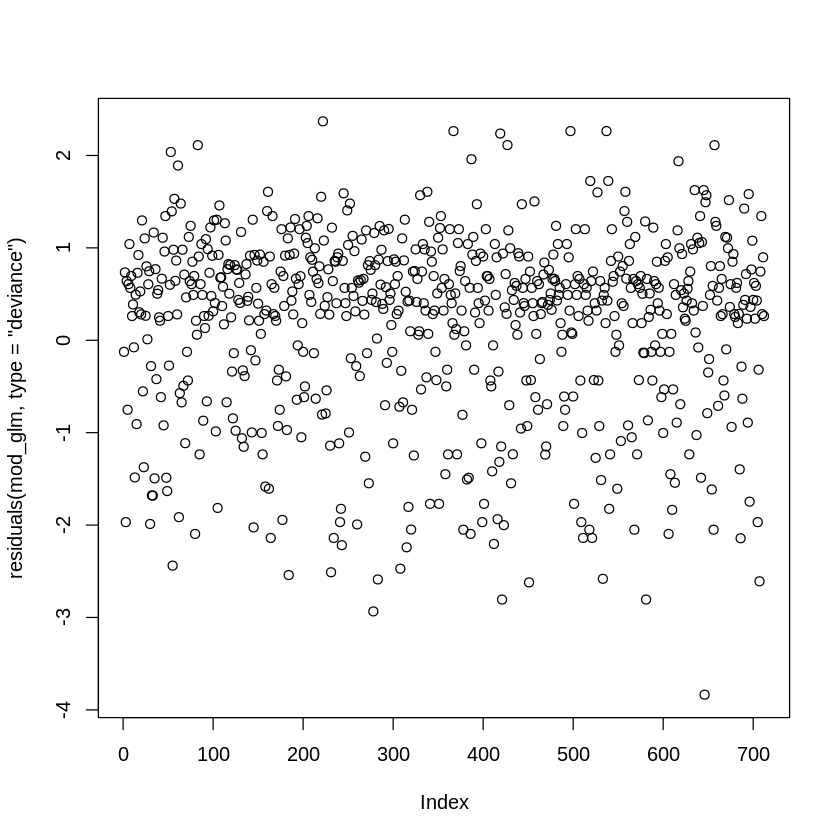

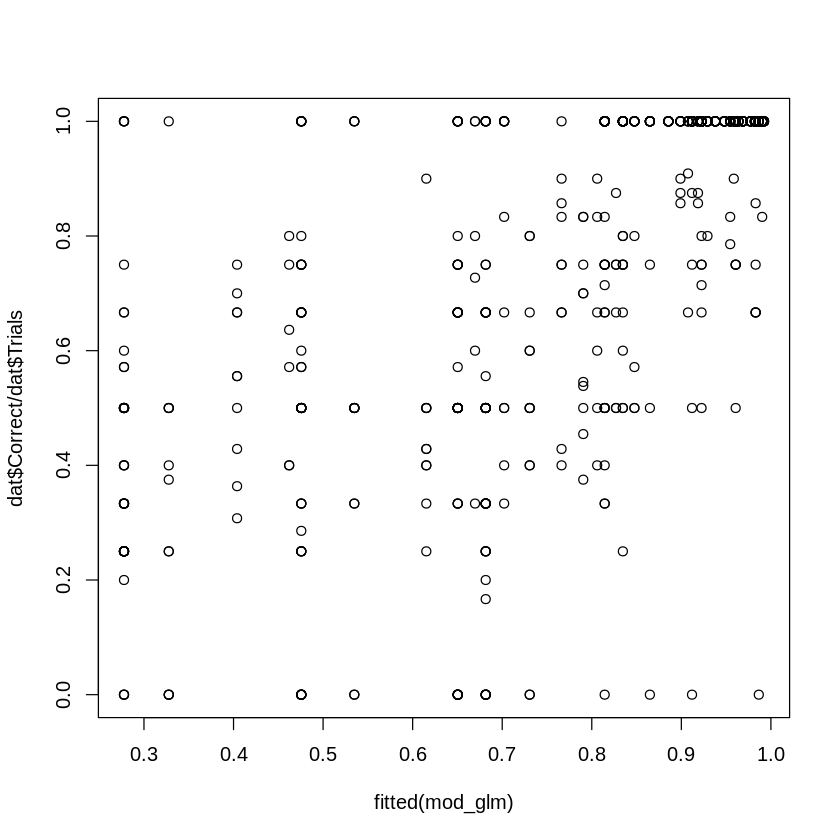

In [3]:
plot(residuals(mod_glm, type="deviance"))
plot(fitted(mod_glm), dat$Correct/dat$Trials)

In [34]:
X = model.matrix(mod_glm)[,-1] # -1 removes the column of 1s for the intercept
head(X)

Age,OMElow,Loud,Noiseincoherent
30,1,35,0
30,1,35,1
30,1,40,0
30,1,40,1
30,1,45,0
30,1,45,1


Age,OMElow,Loud,Noiseincoherent
30,1,35,0
30,1,35,1
30,1,40,0
30,1,40,1
30,1,45,0
30,1,45,1


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 712
   Unobserved stochastic nodes: 5
   Total graph size: 4372

Initializing model



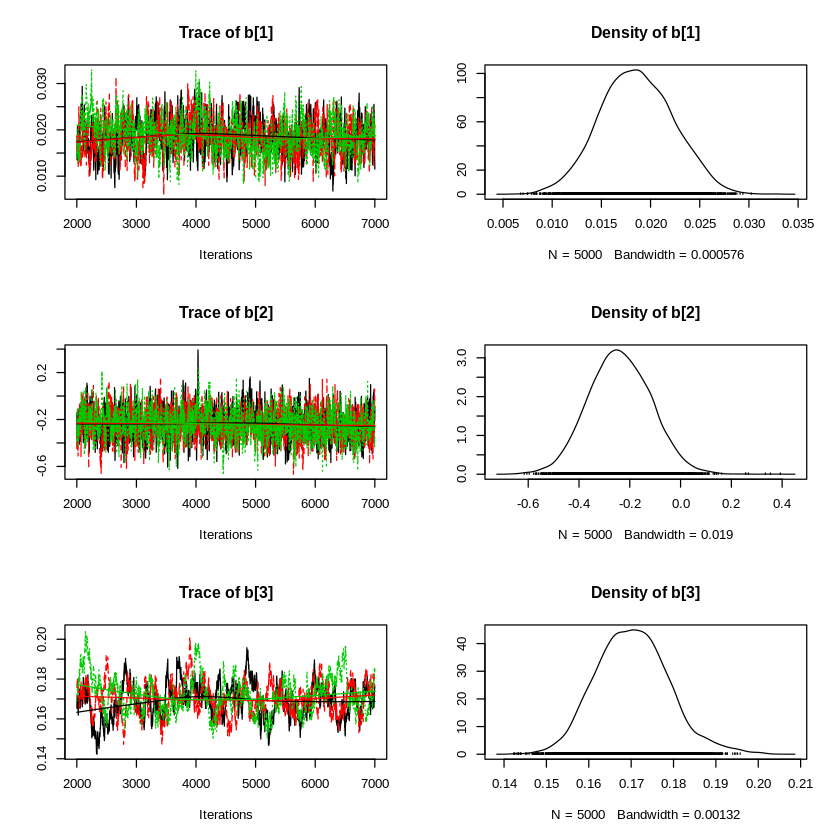

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.00       1.00
b[2]       1.00       1.01
b[3]       1.01       1.02
b[4]       1.00       1.00
b0         1.01       1.01

Multivariate psrf

1

,b[1],b[2],b[3],b[4],b0
Lag 0,1.00000000,1.00000000,1.0000000,1.00000000,1.0000000
Lag 1,0.91711410,0.81938967,0.9836464,0.49060336,0.9879731
Lag 5,0.65464256,0.40509688,0.9220906,0.09781405,0.9395237
Lag 10,0.44152227,0.17866312,0.8530403,0.06216236,0.8823243
Lag 50,0.08897248,-0.01031846,0.4690710,0.04376318,0.5121671


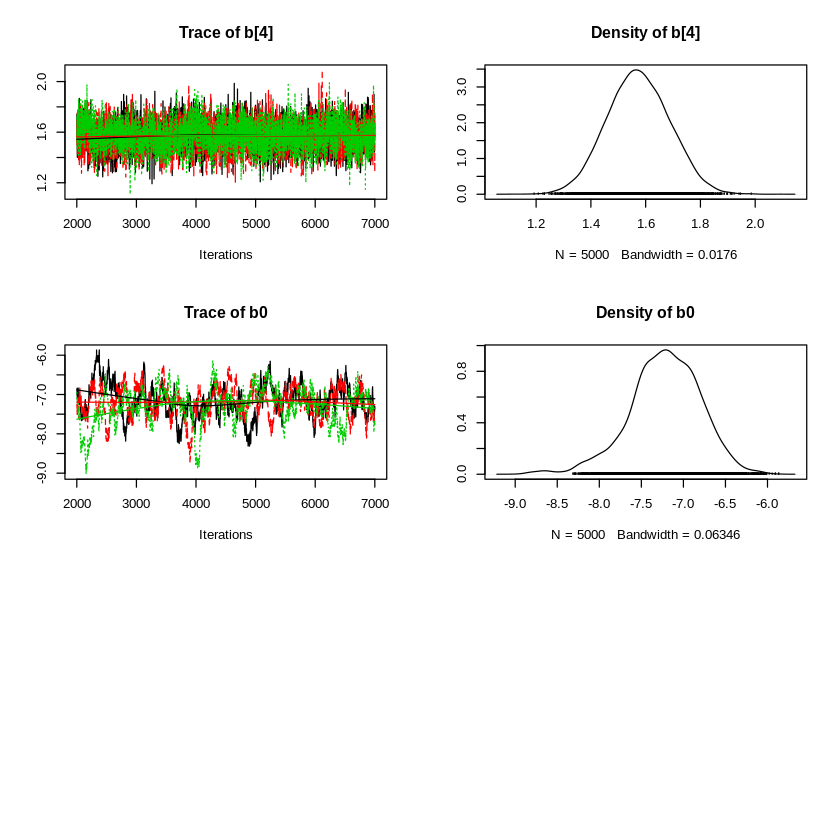

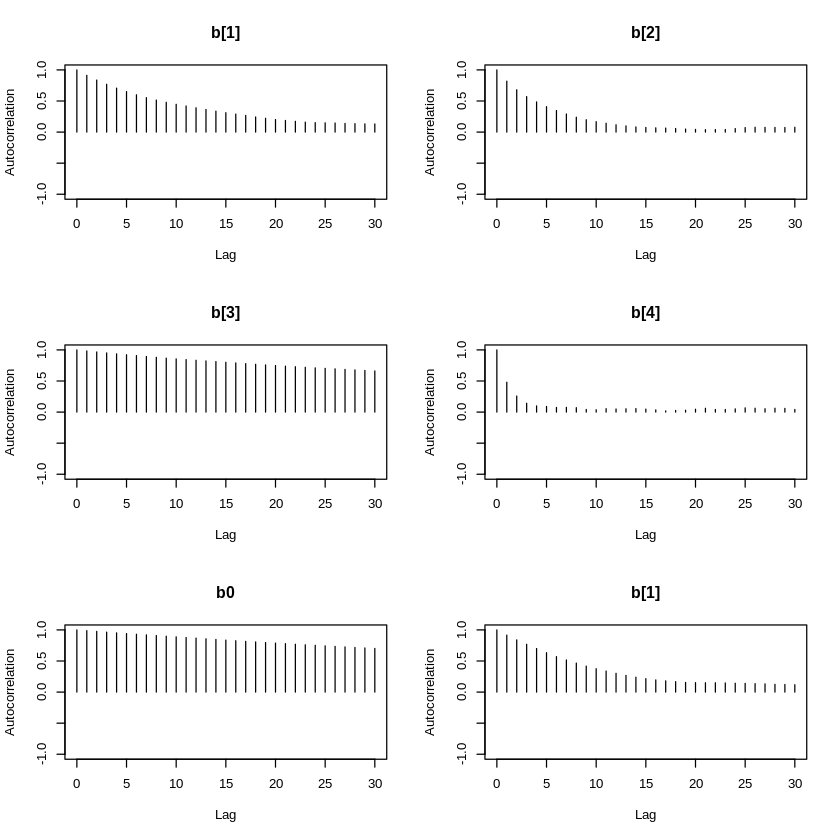

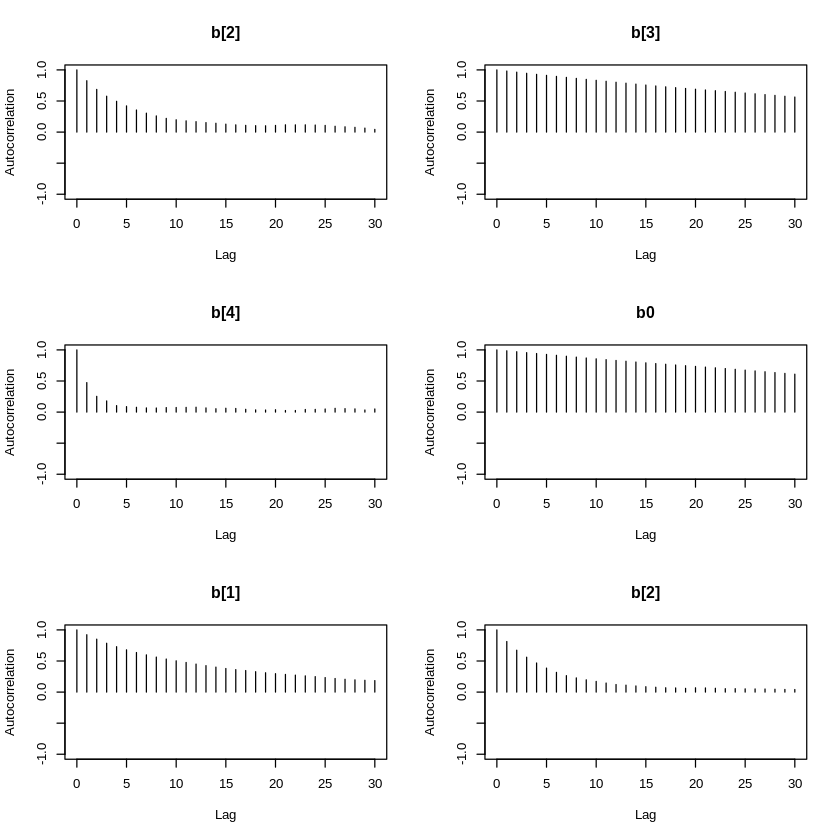

b[1]       b[2]       b[3]       b[4]         b0 
 649.31512 1330.06556  123.65012 2719.37121   92.71975

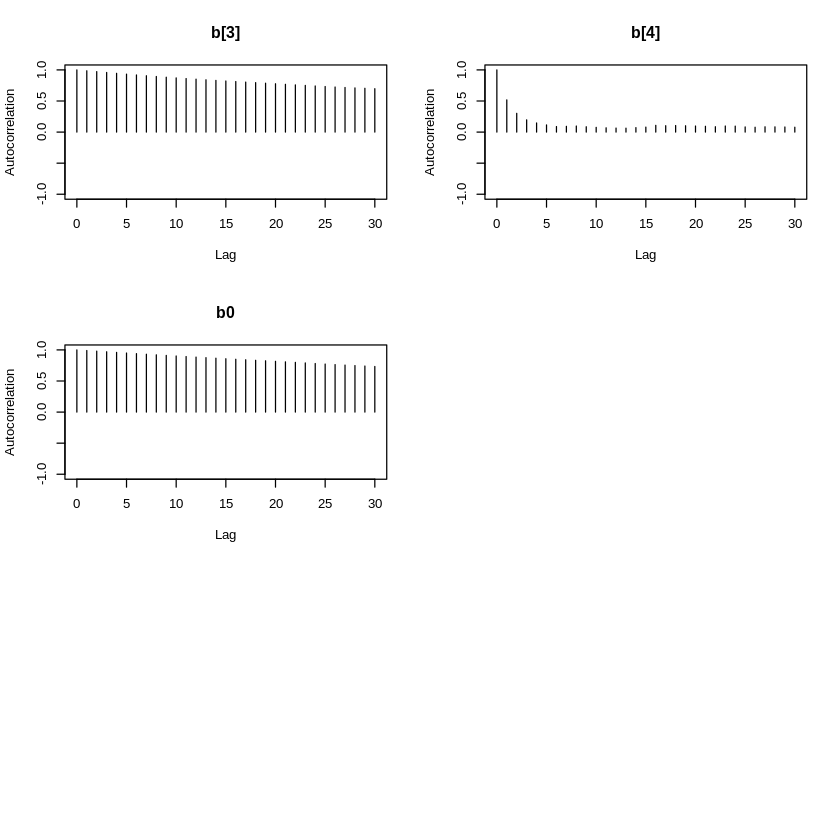

In [40]:
mod1_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dbin(phi[i], n[i])
        logit(phi[i]) = b0 + b[1]*Age[i] + b[2]*OMElow[i] + b[3]*Loud[i] + b[4]*Noiseincoherent[i]
    }
    b0 ~ dnorm(0.0, 1.0/25.0)
    for (j in 1:4) {
        b[j] ~ dnorm(0.0, 1.0/25.0) # has variance 1.0
    }
} "

set.seed(92)
head(X)

data_jags = list(y=dat$Correct, Age=X[,"Age"], OMElow=X[,"OMElow"], Loud=X[,"Loud"], Noiseincoherent=X[,"Noiseincoherent"], n=dat$Trials)

params = c("b0", "b")

mod1 = jags.model(textConnection(mod1_string), data=data_jags, n.chains=3)
update(mod1, 1e3)

mod1_sim = coda.samples(model=mod1,
                        variable.names=params,
                        n.iter=5e3)
mod1_csim = as.mcmc(do.call(rbind, mod1_sim))

## convergence diagnostics
plot(mod1_sim, ask=TRUE)

gelman.diag(mod1_sim)
autocorr.diag(mod1_sim)
autocorr.plot(mod1_sim)
effectiveSize(mod1_sim)

## calculate DIC
dic1 = dic.samples(mod1, n.iter=1e3)

In [41]:
summary(mod1_csim)


Iterations = 1:15000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
b[1]  0.0186 0.003718 3.036e-05      0.0001464
b[2] -0.2394 0.122659 1.002e-03      0.0033776
b[3]  0.1703 0.008589 7.013e-05      0.0007859
b[4]  1.5733 0.113596 9.275e-04      0.0029560
b0   -7.2210 0.426809 3.485e-03      0.0456577

2. Quantiles for each variable:

         2.5%      25%      50%      75%    97.5%
b[1]  0.01147  0.01601  0.01852  0.02116  0.02589
b[2] -0.47345 -0.32341 -0.24157 -0.15607  0.00211
b[3]  0.15480  0.16440  0.17011  0.17582  0.18891
b[4]  1.35396  1.49586  1.57181  1.65030  1.79531
b0   -8.16660 -7.47588 -7.20358 -6.92696 -6.45227


In [42]:
raftery.diag(mod1_csim)


Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 18       18898  3746          5.04     
 b[2] 14       15064  3746          4.02     
 b[3] 75       80151  3746         21.40     
 b[4] 6        6877   3746          1.84     
 b0   198      216312 3746         57.70     


In [50]:
pm_coef = colMeans(mod1_csim)
pm_coef

b[1]        b[2]        b[3]        b[4]          b0 
 0.01859927 -0.23942482  0.17034984  1.57329629 -7.22101446

In [75]:
xb = pm_coef['b0'] + c(60, 0, 50, 0) %*% pm_coef[1:4]
print(1.0 / (1.0 + exp(-xb)))

          [,1]
[1,] 0.9177706


In [74]:
pm_Xb = pm_coef['b0'] + X %*% pm_coef[1:4]
phat = 1.0 / (1.0 + exp(-pm_Xb))
(tab0.7 = table(phat > 0.7, (dat$Correct / dat$Trials) > 0.7))
sum(diag(tab0.7)) / sum(tab0.7)

       
        FALSE TRUE
  FALSE   182   48
  TRUE     63  419

[1] 0.8441011